<br>
<br>
<br>
<div style="text-align: center;">
  <img src="Images/Finetuned.jpg" alt="Finetuned">
</div>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


<div style="text-align: center;">
  <img src="Images/Fewshot.jpg" alt="Fewshot">
</div>
<br>
<br>
<br><br>
<br>
<br><br>
<br>
<br><br>
<br><br>
<br>
<br>
<br>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import random
import sys
import os
import importlib
import utils
import matplotlib.pyplot as plt
import numpy as np
import warnings

current_folder = os.getcwd()
if current_folder not in sys.path:
    sys.path.append(current_folder)
from utils import few_shot_comparison, plot_tsne
from collections import defaultdict
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Few-Shot Learning: Wprowadzenie

Tradycyjne uczenie nadzorowane (supervised learning) opiera się na dużych zbiorach danych z wieloma oznakowanymi (labeled) przykładami na klasę. W przeciwieństwie do tego, **few-shot learning (FSL)** ma na celu umożliwienie klasyfikacji danych nowych klas na **bardzo niewielkiej** liczbie oznakowanych przykładów, nawet 1–5 na klasę.

[Źródło: IBM, 2023](https://www.ibm.com/think/topics/few-shot-learning?.com).

---

## Dlaczego Few-Shot Learning jest przydatne

Few-shot learning jest zaprojektowane dla przypadków, w których standardowe uczenie nadzorowane jest niepraktyczne lub nieefektywne. Poniżej przedstawiono główne powody, dla kiedy metody few-shot są przydatne:

[Źródło: DataCamp, 2023](https://www.datacamp.com/blog/what-is-few-shot-learning?.com).

---

### 1. Dane są drogie lub trudne do zebrania

W wielu dziedzinach zebranie dużych, oznakowanych zbiorów danych jest niemożliwe.  

Przykłady:
- **Obrazowanie medyczne:** wymaga wykwalifikowanego radiologa lub patologa  
- **Rzadkie choroby:** dostępnych jest tylko kilka przypadków pacjentów  
- **Monitoring dzikiej przyrody:** niektóre gatunki są rzadkie, zagrożone lub trudne do sfotografowania  
- **Defekty przemysłowe:** usterki zdarzają się rzadko, więc przykłady są nieliczne  

W takich przypadkach:
- Zebranie tysięcy przykładów na klasę jest nierealistyczne  
- Tradycyjne modele głębokiego uczenia, przy bardzo małych zbiorach danych, przeuczają się (overfit)

Few-shot learning rozwiązuje ten problem poprzez:
- Wykorzystanie **wcześniejszej wiedzy zdobytej z innych danych** (pre-trained models)
- Wymaganie tylko kilku oznakowanych przykładów do rozpoznania nowej klasy  

**Kluczowe założenie:** model już nauczył się reprezentować podobne dane, a kilka przykładów określa tylko to, co nowe 

[Źródło: DataCamp, 2023](https://www.datacamp.com/blog/what-is-few-shot-learning?.com).

---

### 2. Wymagana jest szybka adaptacja do nowych zadań

W wielu zastosowaniach nowe zadania (lub klasy) pojawiają się często i modele muszą się szybko dostosowywać.  

Przykłady:
- **Systemy spersonalizowane:** model dostosowuje się do preferencji nowego użytkownika  
- **Systemy bezpieczeństwa:** pojawiają się nowe wzorce ataków lub anomalie  
- **Robotyka:** roboty napotykają nowe obiekty lub środowiska  
- **Moderacja treści:** pojawiają się nowe rodzaje treści lub trendy  

W takich przypadkach:
- Retraining dużego modelu od zera jest powolny i kosztowny obliczeniowo  
- Zebranie dużych zbiorów danych dla każdego nowego zadania jest niepraktyczne  

Few-shot learning pozwala:
- Dodawać nowe klasy przy użyciu tylko kilku przykładów  
- Unikać pełnego retreningu modelu  
- Bardzo szybko adaptować model  

Dzięki temu FSL jest odpowiednie do uczenia „w locie”

[Źródło: DataCamp, 2023](https://www.datacamp.com/blog/what-is-few-shot-learning?.com).

---

### 3. Efektywne wykorzystanie wcześniej zdobytej wiedzy

Few-shot learning opiera się na założeniu, że modele powinny ponownie wykorzystywać to, czego już się nauczyły.  

Nowoczesne modele uczenia maszynowego są często:
- Wstępnie trenowane na ogromnych zbiorach danych  
- Bogate w reprezentacje ogólnego zastosowania  

Przykłady:
- Modele computer vision trenowane na ImageNet  
- Modele językowe trenowane na dużych korpusach tekstów  
- Modele mowy trenowane na dużych zbiorach danych audio  

Few-shot learning wykorzystuje to poprzez:
- Zachowanie wstępnej reprezentacji bez zmian  
- Użycie kilku przykładów do określenia nowych zadań w przestrzeni reprezentacji  

Zamiast uczyć się od zera:
- Model wykorzystuje podobieństwo, odległość lub kontekst  
- Dzięki temu wiedza ze starych zadań wykorzystywana jest dla nowych

To prowadzi do:
- Lepszej generalizacji  
- Mniejszego zapotrzebowania na dane  
- Efektywniejszego wykorzystania zasobów obliczeniowych

[Źródło: DataCamp, 2023](https://www.datacamp.com/blog/what-is-few-shot-learning?.com)

---

### Podsumowanie

Few-shot learning jest przydatne, gdy:
- Duże oznakowane zbiory danych są niedostępne  
- Wymagana jest szybka adaptacja  

W skrócie: FSL przesuwa fokus z *uczenia się wyłącznie z danych* na *efektywne wykorzystanie już nabytej wiedzy* 

---

### Kluczowe pojęcia

- **N-way K-shot learning:**  
  - **N** = liczba klas do sklasyfikowania  
  - **K** = liczba oznakowanych przykładów na klasę  
  Przykład: 5-way 1-shot = klasyfikacja 5 klas z 1 oznakowanym przykładem każda 

- **Zbiór pomocniczy (Support Set):** mały oznakowany zbiór danych używany do nauki/adaptacji 
- **Zbiór zapytań (Query Set):** zbiór nowych, nieoznakowanych przykładów do sklasyfikowania

[Źródło: Jaimlr, 2023](https://jaimlr.github.io/Journal-of-Artificial-Intelligence-Machine-Learning-Research/few-shot-learning-strategies-by-loveleen-narang.html?.com)


# Metric-Based Few-Shot Learning

**Cel:**  
Zamiast trenować pełny klasyfikator od podstaw, uczymy **przestrzeni cech (embedding space)**, w której mierzymy podobieństwo między przykładami 

[Źródło: IBM, 2023](https://www.ibm.com/think/topics/few-shot-learning?.com).

---

## Przykłady podejść metrycznych

- **Prototypical Networks:** tworzą prototyp każdej z klas na podstawie średniego wektora cech uzyskanego ze zbioru pomocniczego.
- **Matching Networks:** porównują embeddingi punktu ze zbioru zapytań z embeddingami wszystkich puntków ze zbioru pomocniczego przy wykorzystaniu systemu uwagi (attention).  
- **Siamese Networks:** uczą sieć, która bezpośrednio przewiduje, czy dwie próbki są z tej samej klasy — tzn. uczą metryki podobieństwa.

[Źródło: IBM, 2023](https://www.ibm.com/think/topics/few-shot-learning?.com).

---

## Główne założenia Prototypical Networks

1. **Stwórz embeddingi dla wszystkich przykłądów**  
   - Sieć neuronowa (lub inna funkcja) mapuje każdy przykład $x$ na embedding $f(x)$.  
   - Dla poprawnie działającego modelu, embeddingi przykładów tej samej klasy są blisko siebie, a różnych klas daleko.
     
3. **Oblicz „prototyp” każdej klasy**  
   - Dla każdej klasy $c$ oblicz **średni embedding** elementów ze zbioru pomocniczego:  
     $$
     \mathbf{p}_c = \frac{1}{K} \sum_{i=1}^{K} f(x_i^c)
     $$
     gdzie $x_i^c$ to $i$‑ty przykład klasy $c$, a $K$ to moc zbioru pomocniczego na klasę.  
   - Prototyp to tak naprawdę centrum klastra w przestrzeni cech  

4. **Klasyfikacja przykładów zapytań**  
   - Dla nowego przykładu $x_q$ oblicz jego embedding $f(x_q)$.  
   - Zmierz odległość do każdego prototypu (np. odległość euklidesowa lub cosinusowa).  
   - Przypisz $x_q$ do klasy z **najbliższym prototypem**
     
[Źródło: mgx.dev, 2025](https://mgx.dev/insights/few-shot-learning-foundational-principles-methodologies-applications-and-future-directions/125229aa85474e198eda6582b8847abc).

**Intuicja:**  
Wyobraź sobie wykres 2D, gdzie punkty reprezentują cechy przykładów:  
- Punkty tej samej klasy tworzą grupy (*cluster*)  
- Prototypy są „środkiem” każdej grupy  
- Nowe punkty klasyfikowane są na podstawie bliskości do tych środków 

Źródło: [IBM, 2023](https://www.ibm.com/think/topics/few-shot-learning?.com)

---

### Prototypical Networks- cechy

| Cechy | Prototypical Network |
|-------|--------------------|
| Reprezentacja klasy | Prototyp (średnia) |
| Porównanie zapytania | Query ↔ Prototyp |
| Elastyczność | Ograniczona do średniej klasy |
| Złożoność | Niska |

---

### Zalety Prototypical Networks

- Prosta i intuicyjna metoda – prototypy reprezentują „centrum” każdej klasy  
- Wysoka efektywność przy pretrenowanych embeddingach  
- Dodanie nowej klasy wymaga jedynie obliczenia nowego prototypu, bez konieczności trenowania całego modelu  

[Źródło: Snell et al., 2017](https://arxiv.org/abs/1703.05175)


Przykład na rzeczywistych danych:

In [2]:
n_way = 4
k_shot = 5
n_query = 5

In [3]:
transform = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

In [4]:
# Wybieramy losowo n klas ze zbioru danych
classes = random.sample(range(10), n_way)

# Losowo wybieramy k_shot + n_przykładów dla każdej z wylosowanych klas
support_x, support_y, query_x, query_y = [], [], [], []

for c in classes:
    idxs = [i for i, label in enumerate(dataset.targets) if label == c]
    sampled = random.sample(idxs, k_shot + n_query)
    for i, s in enumerate(sampled):
        img, label = dataset[s]
        if i < k_shot:
            support_x.append(img)
            support_y.append(classes.index(label))
        else:
            query_x.append(img)
            query_y.append(classes.index(label))

support_x = torch.stack(support_x).to(device)
support_y = torch.tensor(support_y).to(device)
query_x = torch.stack(query_x).to(device)
query_y = torch.tensor(query_y).to(device)


In [5]:
# backbone model 
model = torchvision.models.resnet18(weights=True) 
model.fc = nn.Identity() 
model = model.to(device) 
model.eval()

with torch.no_grad():
    # embeddings
    support_embeds = model(support_x.to(device)) 
    query_embeds   = model(query_x.to(device))   


In [6]:
#Nearest Neighbor - baza
dists = torch.cdist(query_embeds, support_embeds)  

nn_idx = dists.argmin(dim=1)

logits_pre = support_y[nn_idx]   
pre_preds  = logits_pre
pre_acc    = (pre_preds == query_y).float().mean().item()

In [7]:
# Prototypical Network
support_y = support_y.to(support_embeds.device)

with torch.no_grad():
    prototypes = torch.stack([
        support_embeds[support_y == c].mean(dim=0)
        for c in range(n_way)
    ])

    dists = torch.cdist(query_embeds, prototypes)
    post_preds = dists.argmin(dim=1)

    post_acc = (post_preds.to(device) == query_y).float().mean().item()

In [8]:
few_shot_comparison("Baseline - Nearest Neighbor", "Prototypical Network", pre_acc, post_acc, n_way, k_shot, n_query)

Porównanie skuteczności Few-Shot Learning
----------------------------------------
Liczba klas (n-way): 4, Liczba przykładów na klasę (k-shot): 5, Liczba zapytań na klasę: 5

Dokładność (accuracy) przed few-shot (Baseline - Nearest Neighbor): 0.65
Dokładność (accuracy) po few-shot (Prototypical Network):      0.75

Poprawa dzięki few-shot learning: +0.10


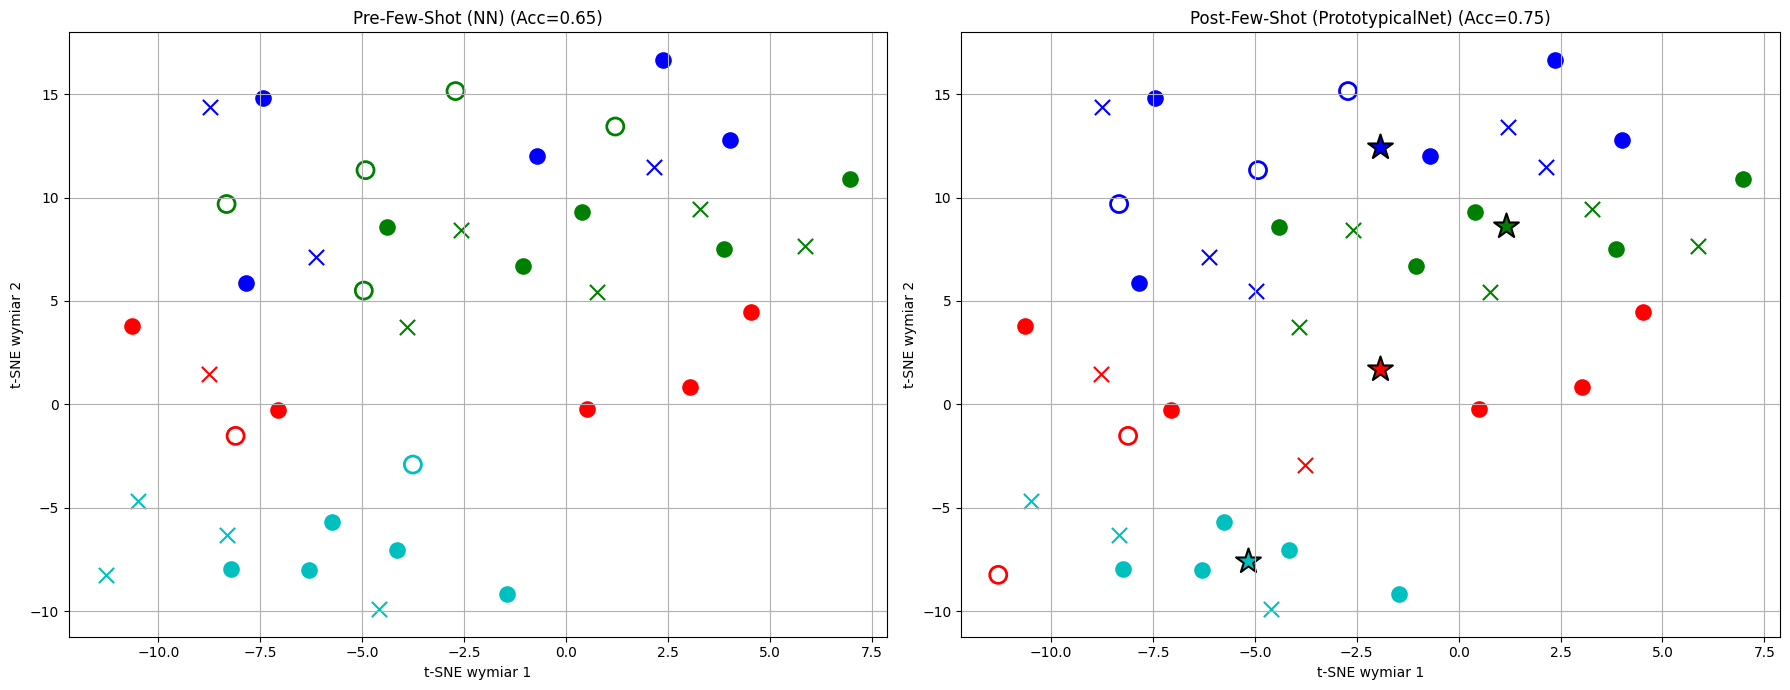

In [9]:
all_embeds = torch.cat([support_embeds, query_embeds], dim=0).cpu().numpy()

tsne = TSNE(n_components=2, random_state=42, perplexity=10)
tsne_embeddings_2d = tsne.fit_transform(all_embeds)

num_support = support_embeds.shape[0]
support_2d = tsne_embeddings_2d[:num_support]
query_2d   = tsne_embeddings_2d[num_support:]

# Obliczamy prototypy w 2D dla t-SNE 
support_y_np = support_y.cpu().numpy()

prototypes_2d = np.stack([
    support_2d[support_y_np == c].mean(axis=0)
    for c in range(n_way)
])


fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Nearest Neighbor 
plot_tsne(
    axes[0],
    pre_preds.cpu().numpy(),
    f"Pre-Few-Shot (NN) (Acc={pre_acc:.2f})",
    n_way,
    support_2d,
    query_2d,
    support_y_np,
    query_y
)

# Prototypical Network
plot_tsne(
    axes[1],
    post_preds.cpu().numpy(),
    f"Post-Few-Shot (PrototypicalNet) (Acc={post_acc:.2f})",
    n_way,
    support_2d,
    query_2d,
    support_y_np,
    query_y,
    show_prototypes=True,
    prototypes_2d=prototypes_2d
)

plt.tight_layout()
plt.show()

# gwaizdy - prototypy
# koła - punkty wsparcia
# pierścienie - źle sklasyfikowane punkty zapytania
# x-y - dobrze sklasyfikowane punkty zapytania 
# wymiary t-SNE to reprezentacja 2D wysokowymiarowych embeddingów, stworzona tak, aby punkty podobne w oryginalnej przestrzeni były blisko siebie w płaszczyźnie.

## Matching Networks - wykorzystanie mechanizmu atencji

Matching Networks to podejście w few-shot learning, które rozszerza ideę Prototypical Networks, porównując każdy przykład zapytania (*query*) ze **wszystkimi** przykładami pomocnyczymi, zamiast obliczać pojedynczy prototyp dla klasy. Pozwala to modelowi uchwycić bardziej szczegółowe relacje w zbiorze pomocniczym, co jest szczególnie przydatne, gdy zbiór danych jest "trudniejszy".
[Źródło: Vinyals et al., 2016](https://arxiv.org/abs/1606.04080)

---

### Główne mechanizmy

- **Porównanie ze zbiorem pomocniczym:**  
  Każdy embedding zapytania porównywany jest z **każdym** embeddingiem wsparcia za pomocą funkcji podobieństwa (np. podobieństwo cosinusowe lub iloczyn skalarny).

- **Predykcja z wagami atencji:**  
  W Matching Networks predykcja zapytania to **ważona suma etykiet przykładów pomocniczych**, gdzie wagi są wyznaczane na podstawie podobieństwa do zapytania.

  Niech $q$ będzie przykładem zapytania, a $S = \{(x_i, y_i)\}$ zbiorem pomocniczym. Wówczas przewidywana etykieta to:

  $$
  \hat{y}_q = \sum_{i \in S} a(q, x_i) \, y_i
  $$

  Wagi atencji $a(q, x_i)$ oblicza się jako softmax z podobieństw:

  $$
  a(q, x_i) = \frac{\exp(\text{sim}(f(q), f(x_i)))}{\sum_{j \in S} \exp(\text{sim}(f(q), f(x_j)))} \,,
  $$

  gdzie:  
  - $f(\cdot)$ to funkcja tworząca embedding,  
  - $\text{sim}(\cdot, \cdot)$ to funkcja podobieństwa (cosine similarity, iloczyn skalarny),  
  - $y_i$ to klasa przykładu pomocniczego $x_i$ (zwykle zakodowana w postaci one-hot).  

  Dzięki temu zapytanie może "skupić uwagę" na najbardziej istotnych przykładach ze zbioru pomocniczego, ważąc ich wpływ na końcową predykcję.  
  Przewidywana klasa: $argmax(\hat{y}_q)$

- **Embeddingi kontekstowe (rozszerzenie podstawowej metody):**  
W oryginalnej pracy o Matching Networks autorzy kontekstualizują embeddingi przy użyciu BiLSTM w zbiorze pomocniczym. Oznacza to, że każdy przykład „widzi” pozostałe przykłady w zbiorze i może lepiej uwzględniać ich wzajemne relacje podczas klasyfikacji.
BiLSTM (Bidirectional LSTM) to rodzaj sieci rekurencyjnej, która analizuje sekwencje w obu kierunkach, pozwalając modelowi uwzględniać zarówno wcześniejsze, jak i późniejsze przykłady w sekwencji.

   W odróżnieniu od podstawowej wersji, która traktuje każdy przykład ze zbioru pomocniczego niezależnie, kontekstualizacja pozwala modelowi korzystać z informacji o całym     zbiorze wsparcia wraz z uwzględnieniem relacji między punktami w zbiorze wsparcia, co może poprawić wyniki .


[Źródło: Vinyals et al., 2016](https://arxiv.org/abs/1606.04080).

---

### Matching Networks- cechy

| Cechy | Matching Network |
|-------|----------------|
| Reprezentacja klasy | Wszystkie punkty pomocnicze |
| Porównanie zapytania | Query ↔ Wszystkie embeddingi punktów pomocniczych + atencja |
| Elastyczność | Lepiej radzi sobie z "trudniejszymi" zbiorami danych niż poprzednia metoda |
| Złożoność | Wyższa niż w poprzedniej metodzie |


---

### Zalety Matching Networks

- Umożliwia dokładniejsze uchwycenie informacji ze zbioru pomocniczego  
- Lepiej adaptuje się do danych z bardziej złożonych rozkładów  
- Można wykorzystać wizualizowane wag atencji aby uzyskać wgląd w to, które przykłady pomocnicze wpływają na predykcję

[Źródło: Vinyals et al., 2016](https://arxiv.org/abs/1606.04080)

In [10]:
# Matching Network
query_norm = F.normalize(query_embeds, dim=1)
support_norm = F.normalize(support_embeds, dim=1)

sim_matrix = torch.matmul(query_norm, support_norm.T)

attention = torch.softmax(sim_matrix, dim=1)

support_onehot = torch.zeros(support_y.size(0), n_way).to(device)
support_onehot[torch.arange(support_y.size(0)), support_y] = 1

post_preds = attention.to(device) @ support_onehot.to(device)
post_preds = post_preds.argmax(dim=1)

post_acc = (post_preds == query_y).float().mean().item()

In [11]:
few_shot_comparison("Baseline - Nearest Neighbor", "Matching Network", pre_acc, post_acc, n_way, k_shot, n_query)

Porównanie skuteczności Few-Shot Learning
----------------------------------------
Liczba klas (n-way): 4, Liczba przykładów na klasę (k-shot): 5, Liczba zapytań na klasę: 5

Dokładność (accuracy) przed few-shot (Baseline - Nearest Neighbor): 0.65
Dokładność (accuracy) po few-shot (Matching Network):      0.70

Poprawa dzięki few-shot learning: +0.05


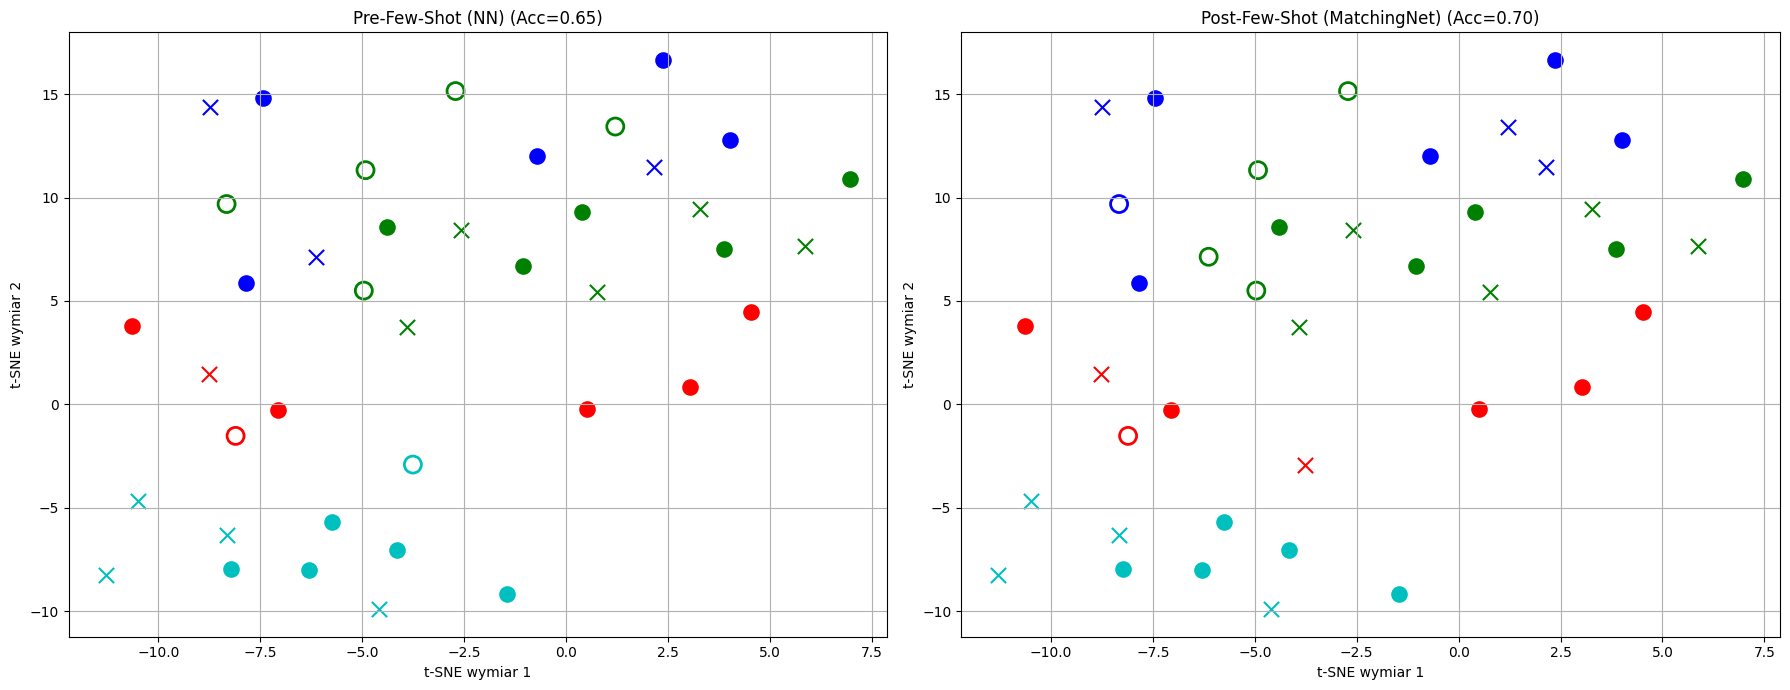

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

plot_tsne(
    axes[0],
    pre_preds.cpu().numpy(),
    f"Pre-Few-Shot (NN) (Acc={pre_acc:.2f})",
    n_way,
    support_2d,
    query_2d,
    support_y_np,
    query_y
)

plot_tsne(
    axes[1],
    post_preds.cpu().numpy(),
    f"Post-Few-Shot (MatchingNet) (Acc={post_acc:.2f})",
    n_way,
    support_2d,
    query_2d,
    support_y_np,
    query_y,
)

plt.tight_layout()
plt.show()

# koła - punkty wsparcia
# pierścienie - źle sklasyfikowane punkty zapytania
# x-y - dobrze sklasyfikowane punkty zapytania 
# wymiary t-SNE to reprezentacja 2D wysokowymiarowych embeddingów, stworzona tak, aby punkty podobne w oryginalnej przestrzeni były blisko siebie w płaszczyźnie.

## Siamese Networks: uczenie poprzez podobieństwa par

Siamese Networks to podejście w few-shot learning, które koncentruje się na **uczeniu funkcji podobieństwa** między parami przykładów, zamiast bezpośrednio przewidywać etykiety klas. Model zamiast „uczyć się etykiet”, uczy się „czy dwa przykłady są podobne”. Pozwala łatwo odróżniać klasy, których model wcześniej nie widział. Można zauważyć, że Siamese Networks działają podobnie do SimCLR, ponieważ uczą się reprezentacji poprzez porównywanie par przykładów.

[Źródło: Koch et al., 2015](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).

---

### Główne mechanizmy

- **Porównanie parami:**  
  Sieć przyjmuje **dwa wejścia naraz** i zwraca wynik podobieństwa.  
  Odpowiada na pytanie „czy te dwa przykłady pochodzą z tej samej klasy?”

- **Wspólna sieć embeddingów:**  
  Oba wejścia przechodzą przez tę samą sieć tworzącą ich embeddingi $f_\theta(\cdot)$, aby ich reprezentacje znajdowały się w tej samej przestrzeni cech.

  Niech $x_1, x_2$ będą dwoma przykładami, wówczas:
  $$
  h_1 = f_\theta(x_1), \quad h_2 = f_\theta(x_2)
  $$

- **Funkcja podobieństwa:**  
  Na embeddingach stosuje się metrykę odległości lub podobieństwa (np. L1, L2, cosinus):
  $$
  d(x_1, x_2) = \| h_1 - h_2 \|_1 \quad \text{lub} \quad d(x_1, x_2) = \text{cosine}(h_1, h_2)
  $$

- **Trening z kontrastową stratą:**  
  Pary przykładów są oznakowane jako **podobne (ta sama klasa)** lub **niepodobne (różne klasy)**.  
  Sieć uczy się minimalizować odległość dla podobnych par i **maksymalizować odległość dla niepodobnych par.

  Przykład: kontrastowa strata (*contrastive loss*):
  $$
  \mathcal{L} = y \cdot d(x_1, x_2)^2 + (1-y) \cdot \max(0, m - d(x_1, x_2))^2
  $$
  gdzie:  
  - $y = 1$ jeśli ta sama klasa, w przeciwnym razie 0  
  - $m$ = margines dla par niepodobnych  

- **Predykcja:**  
  Podczas testu zapytanie porównywane jest z przykładami pomocniczymi.  
  Klasa najbliższego przykładu ze zbioru pomocniczego (nearest neighbor) jest przypisywana zapytaniu.

---

### Siamese Network - cechy

| Cechy | Siamese Network |
|-------|----------------|
| Reprezentacja klasy | Embeddingi parami |
| Porównanie zapytania | Query ↔ Pojedynczy przykład wsparcia |
| Elastyczność | Bardzo wysoka |
| Złożoność | Wysoka w porównaniu z poprzednimi dwoma metodami, wymaga rzeczywistego treningu modelu (lub ostatniej warstwy)


---

### Zalety Siamese Networks

- Łatwo **generalizuje do nieznanych klas**  
- Uczy **niezależnej od klasy funkcji podobieństwa**  
- Wymaga tylko **etykiet par**, nie pełnej informacji o klasach  
- Elastyczne: działa nawet przy **jednym przykładzie na klasę**

[Źródło: Koch et al., 2015](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

margin = 1.0  # dla kontrastowej straty
lr = 1e-3     
n_epochs = 100 

# --- Przygotowanie par do trenowania ---
def create_pairs(embeds, labels):
    pairs = []
    targets = []
    n = len(labels)
    for i in range(n):
        for j in range(i+1, n):
            pairs.append((embeds[i], embeds[j]))
            targets.append(1 if labels[i] == labels[j] else 0)
    return torch.stack([torch.stack([p[0], p[1]]) for p in pairs]), torch.tensor(targets, dtype=torch.float32)

backbone = model 

# Uczymy tylko dodatkową warstwę 
embedding_dim = support_embeds.shape[1]
projection = nn.Sequential(
    nn.Linear(embedding_dim, 256),
    nn.ReLU(),
    nn.Linear(256, 128)
).to(device)

optimizer = torch.optim.Adam(projection.parameters(), lr=lr)

# Trenowanie na zbiorze pomocniczym
support_embeds_detach = support_embeds.detach()  # nie trenujemy backbone

pairs, targets = create_pairs(support_embeds_detach, support_y)
pairs, targets = pairs.to(device), targets.to(device)

for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Embeddingi z warstwy projekcji
    p1 = projection(pairs[:,0])
    p2 = projection(pairs[:,1])
    
    # Kontrastowa strata
    distances = F.pairwise_distance(p1, p2)
    loss = (targets * distances.pow(2) + 
            (1 - targets) * F.relu(margin - distances).pow(2)).mean()
    
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")

# predykcja dla zapytań ---
with torch.no_grad():
    support_proj = projection(support_embeds)
    query_proj   = projection(query_embeds)
    
    # Macierz podobieństw (cosine similarity)
    support_norm = F.normalize(support_proj, dim=1)
    query_norm   = F.normalize(query_proj, dim=1)
    sim_matrix = torch.matmul(query_norm, support_norm.T)
    
    # Nearest neighbor
    max_indices = sim_matrix.argmax(dim=1)
    post_preds = support_y[max_indices]
    
    post_acc = (post_preds == query_y).float().mean().item()
    print(f"\nDokładność po trenowaniu Siamese Network: {post_acc:.4f}")


Epoch 10/100, Loss: 0.0412
Epoch 20/100, Loss: 0.0083
Epoch 30/100, Loss: 0.0030
Epoch 40/100, Loss: 0.0010
Epoch 50/100, Loss: 0.0004
Epoch 60/100, Loss: 0.0001
Epoch 70/100, Loss: 0.0000
Epoch 80/100, Loss: 0.0000
Epoch 90/100, Loss: 0.0000
Epoch 100/100, Loss: 0.0000

Dokładność po trenowaniu Siamese Network: 0.7000


In [14]:
few_shot_comparison("Baseline - Nearest Neighbor", "Siamese Network", pre_acc, post_acc, n_way, k_shot, n_query)

Porównanie skuteczności Few-Shot Learning
----------------------------------------
Liczba klas (n-way): 4, Liczba przykładów na klasę (k-shot): 5, Liczba zapytań na klasę: 5

Dokładność (accuracy) przed few-shot (Baseline - Nearest Neighbor): 0.65
Dokładność (accuracy) po few-shot (Siamese Network):      0.70

Poprawa dzięki few-shot learning: +0.05


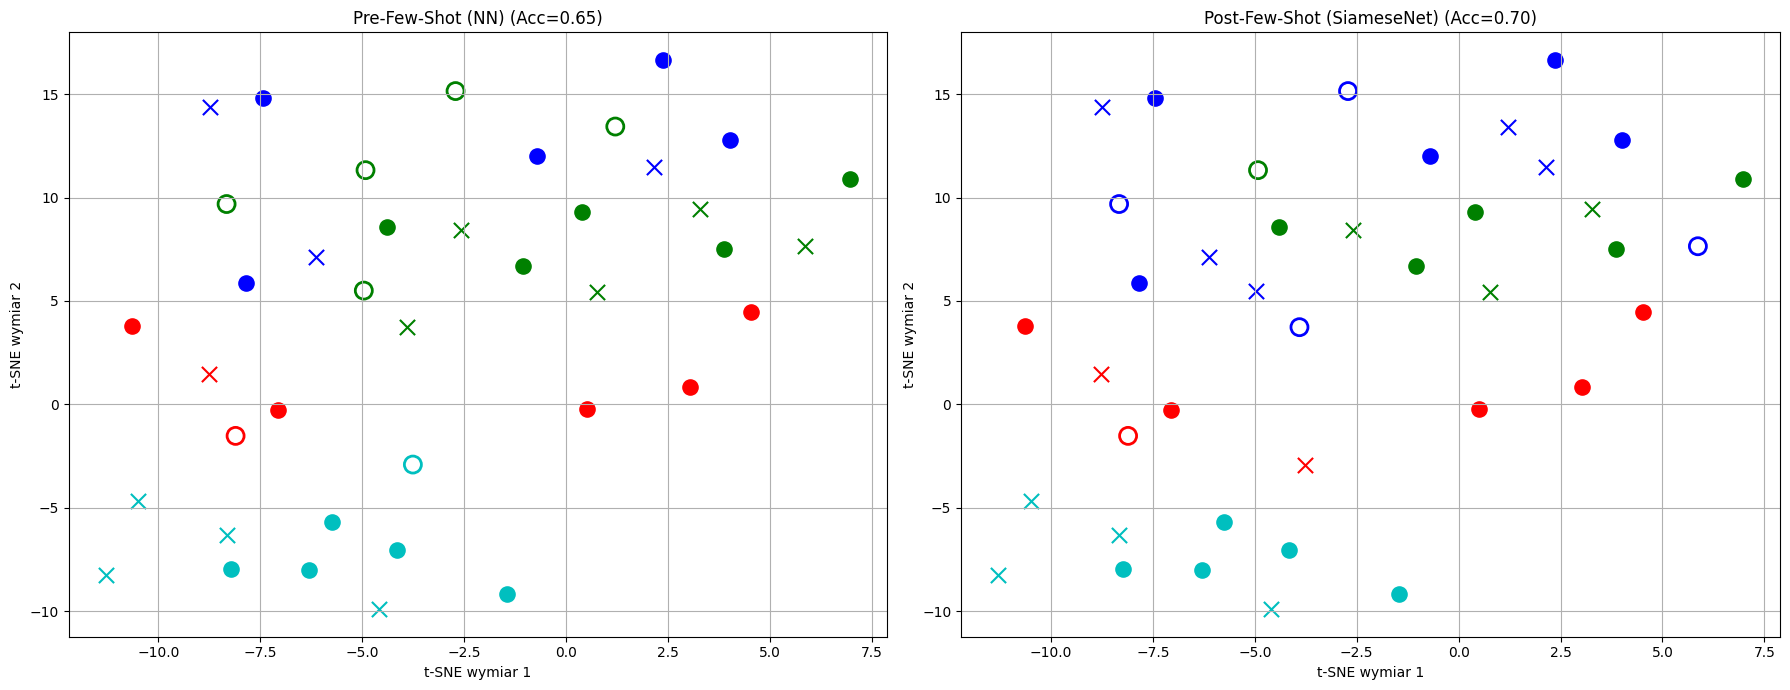

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

plot_tsne(
    axes[0],
    pre_preds.cpu().numpy(),
    f"Pre-Few-Shot (NN) (Acc={pre_acc:.2f})",
    n_way,
    support_2d,
    query_2d,
    support_y_np,
    query_y
)

plot_tsne(
    axes[1],
    post_preds.cpu().numpy(),
    f"Post-Few-Shot (SiameseNet) (Acc={post_acc:.2f})",
    n_way,
    support_2d,
    query_2d,
    support_y_np,
    query_y,
)

plt.tight_layout()
plt.show()

#circles - support points
#rings - misclassified query points
#x-es - well classified query points

## Podsumowanie

### Dlaczego metody metryczne działają w Few-Shot Learning?

- **Nie trzeba trenować dużego klasyfikatora** – wystarczy porównywać odległości, ewentualnie dodać i dotrenować ostatnią wartstwę.  
- **Wykorzystują wcześniej wyuczone reprezentacje cech** – sieć embeddingów może być wstępnie wytrenowana na innych danych.  
- **Skalowalne do nowych klas** – dodanie nowej klasy jest proste, nie wymaga treningu całego modelu na nowo.  

**W skrócie:** Few-shot learning oparty na metrykach zakłąda klasyfikację na podstawie odległości między embeddingami stworzonymi przed wcześniej wytrenowany model.

### Porównanie przedstawionych metod metrycznych: 

| Cechy | Prototypical Network | Matching Network | Siamese Network |
|-------|--------------------|----------------|----------------|
| Reprezentacja klasy | Prototyp (średnia) | Wszystkie punkty pomocnicze | Embeddingi parami |
| Porównanie zapytania | Query ↔ Prototyp | Query ↔ Wszystkie embeddingi punktów pomocniczych + atencja | Query ↔ Pojedynczy przykład wsparcia |
| Elastyczność | Ograniczona do średniej klasy | Lepiej radzi sobie z "trudniejszymi" zbiorami danych niż poprzednia metoda | Bardzo wysoka |
| Złożoność | Niska | Wyższa niż w poprzedniej metodzie | Wysoka w porównaniu z poprzednimi dwoma metodami, wymaga rzeczywistego treningu modelu (lub ostatniej warstwy) |


### Ćwiczenie 1 (obowiązkowe): Odpowiedz na pytanie

**Pytanie:**  
Dlaczego niektóre punkty na wizualizacji t-SNE wydają się być otoczone punktami tej samej klasy, a mimo to są oznaczone jako błędnie sklasyfikowane? Innymi słowy, dlaczego punkty, które wizualnie wydają się „w odpowiednim klastrze”, mają niepoprawne przewidywane etykiety? (Wymień przynajmniej 2 powody)
